In [35]:
import numpy as np
import emnist  

# Load the EMNIST dataset for digits (0-9) and uppercase letters (A-Z)
train_images_digits, train_labels_digits = emnist.extract_training_samples('digits')
test_images_digits, test_labels_digits = emnist.extract_test_samples('digits')
train_images_letters, train_labels_letters = emnist.extract_training_samples('letters')
test_images_letters, test_labels_letters = emnist.extract_test_samples('letters')

# Combine the datasets
# take 50,000 from each
train_images = np.concatenate((train_images_digits, train_images_letters), axis=0)
train_labels = np.concatenate((train_labels_digits, train_labels_letters + 10), axis=0)
test_images = np.concatenate((test_images_digits, test_images_letters), axis=0)
test_labels = np.concatenate((test_labels_digits, test_labels_letters + 10), axis=0)

# Shuffle the data
perm = np.random.permutation(train_images.shape[0])
train_images = train_images[perm]
train_labels = train_labels[perm]

# Reshape and normalize the images
train_images_float32 = train_images.reshape(train_images.shape[0], -1).astype(np.float32) / 255.0
test_images_float32 = test_images.reshape(test_images.shape[0], -1).astype(np.float32) / 255.0
test_images_float32 = test_images_float32.reshape(test_images_float32.shape[0], test_images_float32.shape[1], 1)
train_images_float32 = train_images_float32.reshape(train_images_float32.shape[0], train_images_float32.shape[1], 1)

# Print the shape of the new arrays
print("Train images shape (reshaped):", train_images_float32.shape)
print("Test images shape (reshaped):", test_images_float32.shape)


Train images shape (reshaped): (364800, 784, 1)
Test images shape (reshaped): (60800, 784, 1)


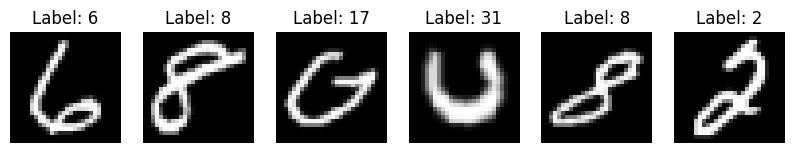

In [36]:
import matplotlib.pyplot as plt
# Define a function to display sample images
def show_images(images, labels, num_images=6):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    
show_images(train_images[-6:], train_labels[-6:])

In [37]:
# Define input and output sizes
input_size = train_images_float32.shape[1]
output_size = len(np.unique(train_labels)) +1

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

train_labels_onehot = one_hot_encode(train_labels, output_size)
test_labels_onehot = one_hot_encode(test_labels, output_size)
# reshaping the one hot encodings
train_labels_onehot = train_labels_onehot.reshape(train_labels_onehot.shape[0], train_labels_onehot.shape[1], 1)
test_labels_onehot = test_labels_onehot.reshape(test_labels_onehot.shape[0], test_labels_onehot.shape[1], 1)

In [38]:
from tqdm import tqdm

# Create and train the neural network
class NeuralNetwork:
    # initialising the sizes of layers
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        # Initialize weights and biases
        self.W1 = np.random.uniform(low=-0.5, high=0.5, size=(self.hidden_size, self.input_size)).astype(np.float32)
        self.b1 = np.random.uniform(low=-0.5, high=0.5, size=(self.hidden_size, 1)).astype(np.float32)
        self.W2 = np.random.uniform(low=-0.5, high=0.5, size=(self.output_size, self.hidden_size)).astype(np.float32)
        self.b2 = np.random.uniform(low=-0.5, high=0.5, size=(self.output_size, 1)).astype(np.float32)

    # we are using the sigmoid activation function
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    # the derivative of the sigmoid activation function
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    # forward pass 
    def forward(self, X):
        # straightforward, just the matrix multiplication of 
        # weights and inputs and addition with biases
        self.z1 = np.dot(self.W1, X) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.W2, self.a1) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    # backward pass
    def backward(self, X, y, output):
        # calculating the two deltas
        delta_output = (y - output)*self.sigmoid_derivative(output)
        delta_hidden = np.dot(self.W2.T, delta_output) * self.sigmoid_derivative(self.a1)
        
        # the change of weights, to be added to weights later
        dW2 = self.learning_rate * np.dot(delta_output, self.a1.T)
        db2 = self.learning_rate * np.sum(delta_output, axis=1, keepdims=True)
        dW1 = self.learning_rate * np.dot(delta_hidden, X.T)
        db1 = self.learning_rate * np.sum(delta_hidden, axis=1, keepdims=True)
        
        # updating weights
        self.W2 += dW2
        self.b2 += db2
        self.W1 += dW1
        self.b1 += db1
    
    # training function
    def train(self, X, y, epochs=20, learning_rate=0.01):
        for epoch in tqdm(range(epochs)):
            for i in range(len(X)):
                temp_output = self.forward(X[i])
                self.backward(X[i], y[i], temp_output)
            error = np.mean(np.square(y-temp_output))
            # checking accuracy on the test data
            print("accuracy (test) : ",self.evaluate(test_images_float32, test_labels_onehot),"%")
            # printing epoch and error
            print(f'Epoch: {epoch}, Error: {error}')
    
    # evaluation function, to evaluate the model on the test data 
    def evaluate(self, X, y):
        count = 0
        for i in range(len(X)):
            temp_output = self.forward(X[i])
            if np.argmax(temp_output) == np.argmax(y[i]):
                count += 1
        return (count/len(X))*100
    

In [39]:
# Define neural network parameters
hidden_size = 32 # Adjust as needed

# Train the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(train_images_float32, train_labels_onehot)

  5%|▌         | 1/20 [01:19<25:12, 79.58s/it]

accuracy (test) :  64.47697368421052 %
Epoch: 0, Error: 0.045236412219067816


 10%|█         | 2/20 [02:41<24:18, 81.05s/it]

accuracy (test) :  69.87664473684211 %
Epoch: 1, Error: 0.0468829289315631


 15%|█▌        | 3/20 [04:03<23:03, 81.36s/it]

accuracy (test) :  73.20394736842105 %
Epoch: 2, Error: 0.04704821883857352


 20%|██        | 4/20 [05:24<21:43, 81.46s/it]

accuracy (test) :  76.0625 %
Epoch: 3, Error: 0.047055722960307834


 25%|██▌       | 5/20 [06:48<20:35, 82.36s/it]

accuracy (test) :  77.34868421052632 %
Epoch: 4, Error: 0.04736708492929407


 30%|███       | 6/20 [08:12<19:19, 82.84s/it]

accuracy (test) :  78.22697368421052 %
Epoch: 5, Error: 0.04796345328944928


 35%|███▌      | 7/20 [09:33<17:49, 82.25s/it]

accuracy (test) :  78.75986842105263 %
Epoch: 6, Error: 0.04831824542342782


 40%|████      | 8/20 [10:54<16:21, 81.80s/it]

accuracy (test) :  79.15625 %
Epoch: 7, Error: 0.04828376376827644


 45%|████▌     | 9/20 [12:14<14:54, 81.32s/it]

accuracy (test) :  79.56085526315789 %
Epoch: 8, Error: 0.04813870262236853
